In [169]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os

In [170]:
print(plt.rcParams["figure.figsize"] )
backupPlotSize = [6.0, 4.0]

[6.0, 4.0]


## 1.a) 

## 1.b) Derivative of 1-d Gaussian

In [171]:
def getGaussianKernel(stDev):
    kerSize = int(2*3*stDev + 1)
    x=np.arange(-(kerSize // 2),(kerSize // 2)+1 )
    gaus = np.exp(-(x**2)/(2*stDev**2))/ (np.sqrt(2*np.pi)*stDev)
    gaus = gaus/sum(gaus)
    return np.array([gaus])


def getGaussianDx(stDev):
    kerSize = int(6*stDev + 1)
    x=np.arange(-(kerSize // 2),(kerSize // 2)+1 )
    gaus = -x*np.exp(-(x*x)/(2*stDev*stDev))/ (np.sqrt(2*np.pi)*stDev*stDev*stDev)
    gaus = gaus/sum(np.abs(gaus))
    return np.array([gaus])

#dva filtra da, ful packasto uglavnem
def applyFilter2(image, kernel1, kernel2):
    kernel1 = np.flip(kernel1)
    kernel2 = np.flip(kernel2)

    imageFiltered = cv2.filter2D(image, ddepth=-1, kernel=kernel1)
    imageFiltered = cv2.filter2D(imageFiltered, ddepth=-1, kernel=kernel2)

    return imageFiltered

def applyFilter(image, kernel):
    #dvakrat gremo skoz, enkrat transponiramo namest n^2 -> 2n
    imageFiltered = cv2.filter2D(image, ddepth=-1, kernel=kernel)
    imageFiltered = cv2.filter2D(imageFiltered, ddepth=-1, kernel=kernel.T)

    return imageFiltered



## 1.c) Impulse response

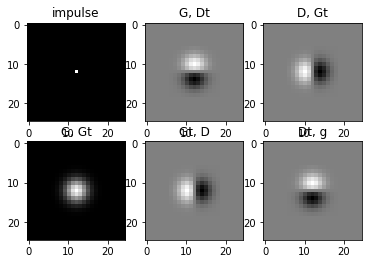

In [172]:
impulse = np.zeros((25,25))
impulse[12,12]=255

gausKer = getGaussianKernel(2)
gausKerDx = getGaussianDx(2)


plt.imshow(impulse, cmap="gray")

gdt = applyFilter2(impulse, gausKer, gausKerDx.T)
dgt = applyFilter2(impulse, gausKerDx, gausKer.T)
ggt = applyFilter2(impulse, gausKer, gausKer.T)
gtd = applyFilter2(impulse, gausKer.T, gausKerDx)
dtg = applyFilter2(impulse, gausKerDx.T, gausKer)


plt.rcParams["figure.figsize"] = [20,10]

plt.subplot(2,3,1)
plt.title("impulse")
plt.imshow(impulse, cmap="gray")


plt.subplot(2,3,2)
plt.title("G, Dt")
plt.imshow(gdt, cmap="gray")


plt.subplot(2,3,3)
plt.title("D, Gt")
plt.imshow(dgt, cmap="gray")


plt.subplot(2,3,4)
plt.title("G, Gt")
plt.imshow(ggt, cmap="gray")

plt.subplot(2,3,5)
plt.title("Gt, D")
plt.imshow(gtd, cmap="gray")

plt.subplot(2,3,6)
plt.title("Dt, g")
plt.imshow(dtg, cmap="gray")

#plt.rcParams["figure.figsize"] = backupPlotSize




## 1.d) Partial of images

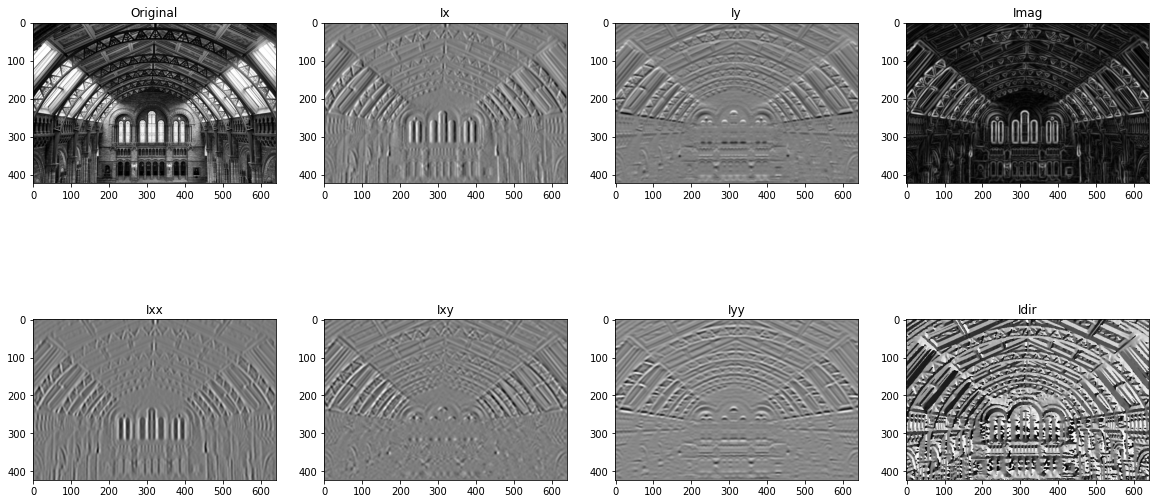

In [173]:
museum = cv2.imread("images/museum.jpg")
museum = cv2.cvtColor(museum, cv2.COLOR_BGR2GRAY)

#plt.rcParams["figure.figsize"] = backupPlotSize
plt.imshow(museum)

museum = museum.astype(float)

Ix = applyFilter2(museum, gausKer.T, gausKerDx)
Ixx = applyFilter2(Ix, gausKer.T, gausKerDx)
Ixy = applyFilter2(Ix, gausKer, gausKerDx.T)

Iy = applyFilter2(museum, gausKer, gausKerDx.T)
Iyx = applyFilter2(Iy, gausKer.T, gausKerDx)
Iyy = applyFilter2(Iy, gausKer, gausKerDx.T)

def getGradientMagnitude(I, stDev):
    Ix = applyFilter2(museum, getGaussianKernel(stDev).T, getGaussianDx(stDev))
    Iy = applyFilter2(museum, getGaussianKernel(stDev), getGaussianDx(stDev).T)
    # Ix = applyFilter2(museum, gausKer.T, gausKerDx)
    # Iy = applyFilter2(museum, gausKer, gausKerDx.T)
    magnitude = np.sqrt(Ix**2 + Iy**2)
    angles = np.arctan2(Iy,Ix)

    return magnitude, angles


magnitude, direction = getGradientMagnitude(museum, 2)

plt.rcParams["figure.figsize"] = [20,10]
plt.subplot(2,4,1)
plt.title("Original")
plt.imshow(museum, cmap="gray")

plt.subplot(2,4,2)
plt.title("Ix")
plt.imshow(Ix, cmap="gray")

plt.subplot(2,4,3)
plt.title("Iy")
plt.imshow(Iy, cmap="gray")

plt.subplot(2,4,4)
plt.title("Imag")
plt.imshow(magnitude, cmap="gray")

plt.subplot(2,4,5)
plt.title("Ixx")
plt.imshow(Ixx, cmap="gray")

plt.subplot(2,4,6)
plt.title("Ixy")
plt.imshow(Ixy, cmap="gray")

plt.subplot(2,4,7)
plt.title("Iyy")
plt.imshow(Iyy, cmap="gray")

plt.subplot(2,4,8)
plt.title("Idir")
plt.imshow(direction, cmap="gray")

plt.show()
#plt.rcParams["figure.figsize"] = backupPlotSize

## 1e) Image recognition

In [174]:
## v drugem filu je vsa ostala koda, to bo sam za tale del
def myHist3Gradient(image, nBins):
    magnitude, angles  = getGradientMagnitude(image, 1)
    #height, width = image.shape
    binSize = 8

    #vse so 128*128 hvala bogu
    # 16*16 window torej
    histArray = np.array([])

    for i in range(0,127,16):
        for j in range(0,127,16):
            #windowImage = image[i:i+16, j:j+16]
            histCell = np.zeros(8)
            windowMagnitude = magnitude[i:i+16, j:j+16].reshape(-1)
            windowAngles = angles[i:i+16, j:j+16].reshape(-1)

            for mag,ang in zip(windowMagnitude, windowAngles):
                closest = np.abs(np.array([ang-0, ang - 0.78, ang - 1.57, ang - 2.35, ang - 3.14, ang + 0, ang + 0.78, ang + 1.57, ang + 2.35, ang + 3.14]))
                indexClosest = np.argmin(closest)
                histCell[indexClosest] += mag
        
            histArray = np.concatenate([histArray, histCell])

    return histArray

# 2 Edges

## 2.a) Canny

-3.141592653589793


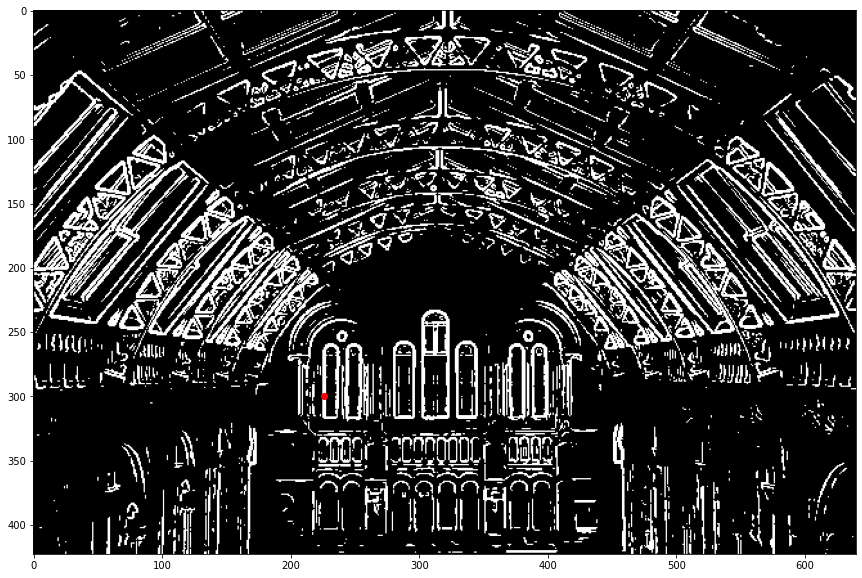

In [175]:
def findEdges(image,  theta, stDev):
    magnitude, direction = getGradientMagnitude(image, stDev)

    image = np.where(magnitude >= theta,1,0)
    return(image)

museum = cv2.imread("images/museum.jpg")
museum = cv2.cvtColor(museum, cv2.COLOR_BGR2GRAY)
museum = museum.astype(float)

museumEdge = findEdges(museum, 30,1)

plt.rcParams["figure.figsize"] = [30,10]

plt.imshow(museumEdge, cmap="gray")
plt.plot(226, 300, marker='o', color="red")

print(np.min(direction))

plt.rcParams["figure.figsize"] = backupPlotSize


## 2.b) Canny

non-maxima supression based on image derivative. 

Za vsak pixel pogledamo ce je max v smeri njegovega gradienta, ta je 1, ce ni najvecji je 0.

Za vsak pixel pogledamo unga v smeri gradienta (naprej pa nazaj tud) 

**8-neighborhood** pomen da ce mas 3*3 pa je pixel v sredini, so sosedje vsi okol, tud diagonale, torej vseh **8** okrog.

Smer gradienta dolocs tko k na enotski premici: g=0 - pogledas levo pa desno, g=0,785398 - gre diagonala desno gor, levo dol, ...

In [176]:
def getMask2(gradient):

    #gradient = np.abs(gradient) #tole verjetno ni okej, treba popravt za diagonale

    levoDesno = np.array([[0,0,0],[1,1,1],[0,0,0]])
    gorDol =  np.array([[0,1,0],[0,1,0],[0,1,0]])
    #tadva sta reversana ne nista <3 somehow
    diagDesnoDol = np.array([[0,0,1],[0,1,0],[1,0,0]])
    diagDesnoGor = np.array([[1,0,0],[0,1,0],[0,0,1]])

    #doloci masko
    mask = levoDesno

    if gradient >= (-2.35-3.14)/2:
        mask = diagDesnoGor
    if gradient >= (-2.35 -1.57)/2:
        mask = gorDol
    # if gradient == 2:
    #     mask = gorDol
    if gradient >= (-1.57 - 0.78)/2:
        mask = diagDesnoDol
    if gradient >= ( 0 - 0.78)/2:
        mask = levoDesno
    if gradient >= (0.78 +0)/2:
        mask = diagDesnoGor
    if gradient >= (1.57 + 0.78)/2:
        mask = gorDol
    if gradient >= (2.35 + 1.57)/2:
        mask = diagDesnoDol
    if gradient >= (3.14 +2.35)/2:
        mask = levoDesno
    

    return mask

(423, 640)


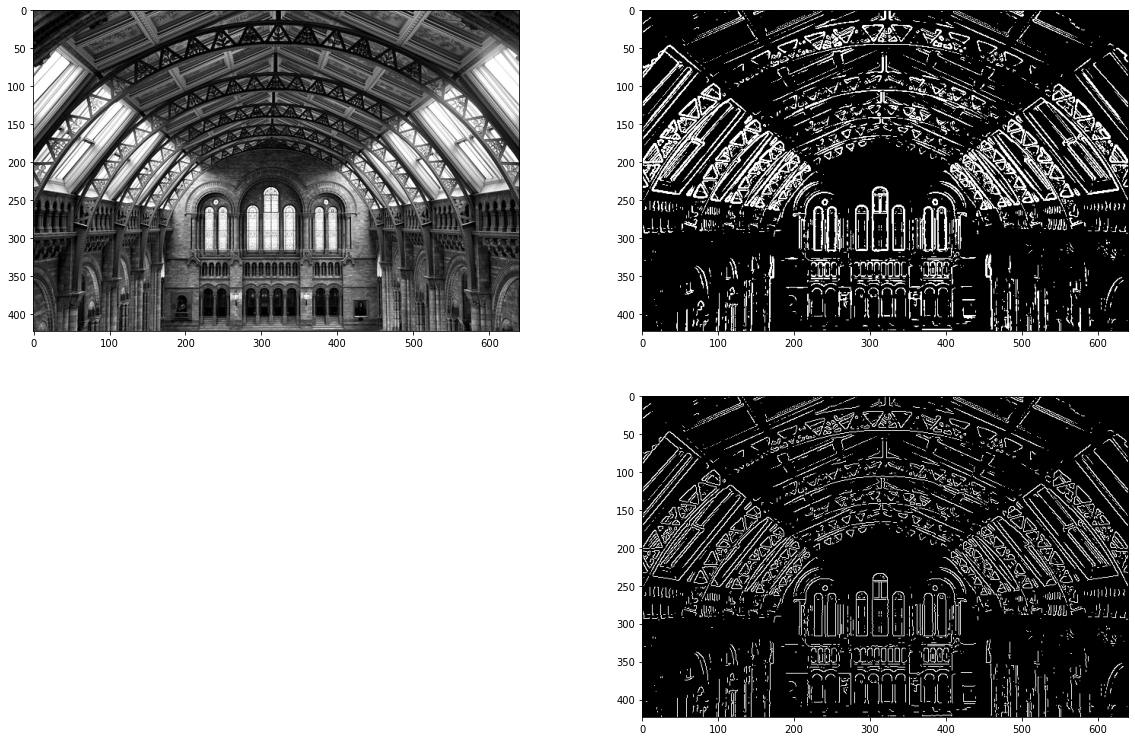

In [177]:
## TODO NEGATIVNE!
#funkcija, ki nam vrne masko glede na smer gradienta, da ves kje iskat maximum:
# 0 pa 3.14 je levo desno 0.785398 je diagonala desno gor levo dol 1.5708 je gor dol 2.35619 je diagonala levo gor desno dol
def getGradientDirectionMask(gradient):

    #gradient = np.abs(gradient) #tole verjetno ni okej, treba popravt za diagonale

    levoDesno = np.array([[0,0,0],[1,1,1],[0,0,0]])
    gorDol =  np.array([[0,1,0],[0,1,0],[0,1,0]])
    diagDesnoGor = np.array([[0,0,1],[0,1,0],[1,0,0]])
    diagDesnoDol = np.array([[1,0,0],[0,1,0],[0,0,1]])

    #zanima nas kjer je najblizji 0 po abs vrednosti
    closest = (np.array([gradient-0, gradient - 0.78, gradient - 1.57, gradient - 2.35, gradient - 3.14, gradient + 0, gradient + 0.78, gradient + 1.57, gradient + 2.35, gradient + 3.14])) ### tej plusi so za negativne
    indexClosest = np.argmin(closest)

    #doloci masko
    if indexClosest == 0:
        mask = levoDesno
    elif indexClosest == 1:
        mask = diagDesnoGor
    elif indexClosest == 2:
        mask = gorDol
    elif indexClosest == 3:
        mask = diagDesnoDol
    elif indexClosest == 4:
        mask = levoDesno
    elif indexClosest == 5:
        mask = levoDesno
    elif indexClosest == 6:
        mask = diagDesnoDol
    elif indexClosest == 7:
        mask = gorDol
    elif indexClosest == 8:
        mask = diagDesnoGor
    else:
        mask = levoDesno

    return mask

def nonMaxima(image):
    magnitude, direction = getGradientMagnitude(image, 1)
    print(magnitude.shape)

    #supressed = np.copy(image)
    image = np.copy(image)

    height, width = image.shape
    image = np.pad(image,1)
    magnitude = np.pad(magnitude,1)
    direction = np.pad(direction, 1)
    

    for x in range(1,height+1):
        for y in range(1, width+1):
            #set the current to 0 if its not the largest in the neighbourhood

            #-1 da bojo indeksi tapravi
            gradientDirection = direction[x,y]

            window = magnitude[x-1:x+2, y-1:y+2]

            #mask = getGradientDirectionMask(gradientDirection)
            mask = getMask2(gradientDirection)

            if image[x,y] == 1 and magnitude[x,y] != np.max(window*mask):
                image[x,y] = 0

    return image[1:height+1, 1: width+1]


supressed = nonMaxima(museumEdge)

plt.rcParams["figure.figsize"] = [20,13]

plt.subplot(2,2,1)
plt.imshow(museum, cmap="gray")
plt.subplot(2,2,2)
plt.imshow(museumEdge, cmap="gray")
plt.subplot(2,2,4)
plt.imshow(supressed, cmap="gray")

#plt.rcParams["figure.figsize"] = backupPlotSize




## 3.c)  Hyterysis

The final step of Canny’s algorithm is edge tracking by hysteresis.
Add the final step after performing non-maxima suppression along edges. Hysteresis
uses two thresholds tlow < thigh, keeps all pixels above thigh and discards all pixels
below tlow. The pixels between the thresholds are kept only if they are connected to
a pixel above thigh

(423, 640)


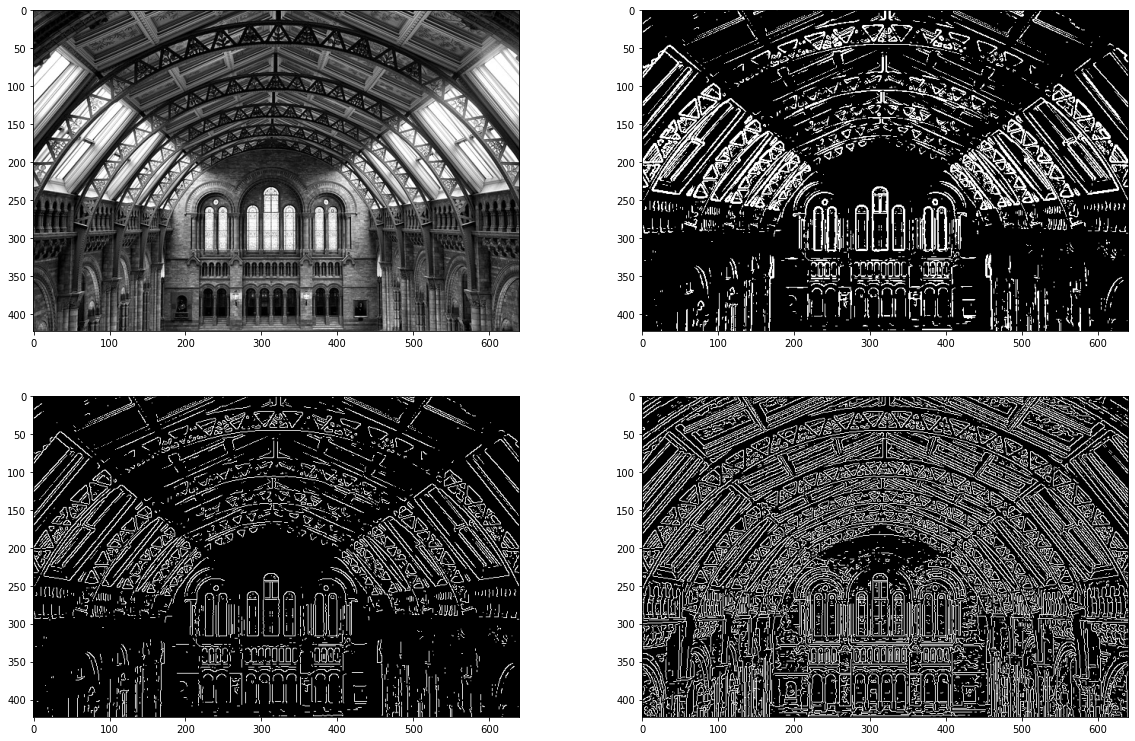

In [178]:
def hysteresisFun(edgeImage, tLow, tHigh, magnitude):
    img = np.copy(edgeImage)
    img = np.uint8(img)
    #plt.imshow(img, cmap="gray")
    #magnitude = np.uint8(magnitude)
    (numLabels, labels, stats, centroids) = cv2.connectedComponentsWithStats(img, 8)
    #print(numLabels)
    for component in range (1,len(labels)):
        #The pixels between the thresholds are kept only if they are connected to a pixel above thigh
        if np.max(magnitude[labels == component]) > tHigh:
            #print("ej")
            img[labels == component] = 1
            #print("hello")

    plt.imshow(img, cmap="gray")
    return img

def hysteresisHelper(image, low, high, stDev):
    magnitude, direction = getGradientMagnitude(image, stDev)

    image = np.where(magnitude >= high, 1,0)
    image = np.where(magnitude <= low,0,1)

    supressed = nonMaxima(image)
    hyst = hysteresisFun(supressed,low,high, magnitude)

    return hyst

#museumEdge = findEdges(museum, 5,1)
#supressed = nonMaxima(museumEdge)
#plt.imshow(supressed, cmap="gray")
#plt.show()

#print(np.max(magnitude))
#print(supressed.shape, magnitude.shape)
#hyst = hysteresis(supressed,1,20, magnitude)

#print(sum(sum(np.not_equal(supressed, hyst))))

hyst = hysteresisHelper(museum, 10, 30, 1)


plt.rcParams["figure.figsize"] = [20,13]
plt.subplot(2,2,1)
plt.imshow(museum, cmap="gray")
plt.subplot(2,2,2)
plt.imshow(museumEdge, cmap="gray")
plt.subplot(223)
plt.imshow(supressed, cmap="gray")
plt.subplot(2,2,4)
plt.imshow(hyst, cmap="gray")



plt.rcParams["figure.figsize"] = backupPlotSize

# 3. Detecting lines

## 3.a) 
A point in $(x,y)$ generates a sinusoid in $(\theta, \rho)$ space.


$x\cos(\theta) + y \sin(\theta) = \rho$

III. The Algorithm

    Decide on the range of ρ and θ. Often, the range of θ is [ 0, 180 ] degrees and ρ is [ -d, d ] where d is the length of the edge image’s diagonal. It is important to quantize the range of ρ and θ meaning there should be a finite number of possible values.

    Create a 2D array called the accumulator representing the Hough Space with dimension (num_rhos, num_thetas) and initialize all its values to zero.

    Perform edge detection on the original image. This can be done with any edge detection algorithm of your choice.

    For every pixel on the edge image, check whether the pixel is an edge pixel. If it is an edge pixel, loop through all possible values of θ, calculate the corresponding ρ, find the θ and ρ index in the accumulator, and increment the accumulator base on those index pairs.
    
    Loop through all the values in the accumulator. If the value is larger than a certain threshold, get the ρ and θ index, get the value of ρ and θ from the index pair which can then be converted back to the form of y = ax + b

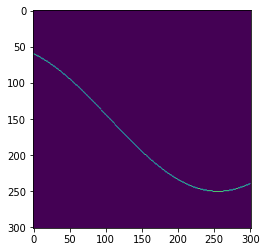

In [179]:

numTheta = 300
numRho = 300
#maxRho = 100

maxRho = 100 #diagonala 

thetas = (np.linspace(-90, 90, numTheta) / 180) * np.pi #hocmo met radiane
rhos = np.linspace(-maxRho, maxRho, numRho)

accumulator = np.zeros((numRho+1, numRho+1))

pointX = 30
pointY = 60

rhosCalculated = pointX*np.cos(thetas) + pointY*np.sin(thetas)

##tale dellaa
for i in range (numTheta):
    #if bin_rho[i] > 0 and bin_rho[i] <= bins_rho:
    rhoCurIndex = np.argmin(np.abs(rhos-rhosCalculated[i]))
    accumulator[rhoCurIndex, i] += 1

# for i in range(numTheta):
#     rhoCur = pointX*np.cos(thetas[i]) + pointY*np.cos(thetas[i])
#     rhoIndex = np.argmin(np.abs(rhos-rhoCur))
#     accumulator[rhoIndex, i] += 1



plt.imshow(accumulator)


1.5707963267948966
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
300.0


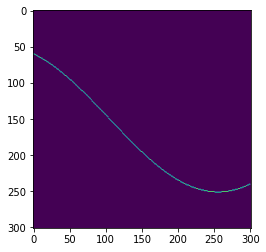

In [180]:
bins_theta = 300
bins_rho = 300 # Resolution of the accumulator array
max_rho = 100 # Usually the diagonal of the image
val_theta = (np.linspace(-90, 90, bins_theta) / 180) * np.pi # Values of theta are known
val_rho = np.linspace(-max_rho, max_rho, bins_rho)
A = np.zeros((bins_rho+1, bins_theta+1))

x = 30
y = 60

print(np.max(val_theta))

rho = x*np.cos(val_theta) + y*np.sin(val_theta)

bin_rho = np.round(((rho + max_rho) / (2*max_rho)) * len(val_rho))
#print(rho+60)

print(A)

for i in range (bins_theta):
    if bin_rho[i] > 0 and bin_rho[i] <= bins_rho:
        A[int(bin_rho[i]), i] += 1

### TALE DELA
# for i in range (bins_theta):
#     #if bin_rho[i] > 0 and bin_rho[i] <= bins_rho:
#     rhoCurIndex = np.argmin(np.abs(val_rho-rho[i]))
#     A[rhoCurIndex, i] += 1

plt.imshow(A)

print(sum(sum(A)))

## Hough find lines function

(732,)
(460,)
(2,)


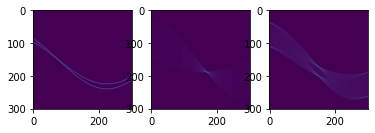

In [181]:

def houghFindLines(image, numTheta, numRho):
    height, width = image.shape

    numTheta = numTheta
    numRho = numRho # Resolution of the accumulator array

    maxRho = np.sqrt(height**2 + width**2) # Usually the diagonal of the image
    
    valuesTheta = (np.linspace(-90, 90, numTheta) / 180) * np.pi # Values of theta are known
    valuesRho = np.linspace(-maxRho, maxRho, numRho)
    accumulatorArray = np.zeros((numRho+1, numTheta+1))

    
    # for y in range(height):
    #     for x in range(width):
    #         if(image[y,x]!=0):
    #             rho = x*np.cos(valuesTheta) + y*np.sin(valuesTheta)
    #             bin_rho =  np.round(((rho + max_rho) / (2 * max_rho)) * len(valuesRho))
    #             for i in range (numTheta):
    #                 if bin_rho[i] > 0 and bin_rho[i] <= numRho:
    #                     A[int(bin_rho[i]), i] += 1

    #vrne indexe nonzero, torej vrne edge pixle a je to pravilno?? al je lih okol? sam idk tko dela tkoda who knows, pomoje je to narobe pa je njihova funkcija tud narobe
    x,y = np.nonzero(image)

    print(y.shape)

    for i in range(len(x)):
        rho = x[i]*np.cos(valuesTheta) + y[i]*np.sin(valuesTheta)
        
        for j in range (numTheta):
            #if bin_rho[i] > 0 and bin_rho[i] <= numRho:
            rhoCurIndex = np.argmin(np.abs(valuesRho-rho[j]))
            accumulatorArray[rhoCurIndex, j] += 1
        
        ###################### FASTER #################################
        # rho = x[i]*np.cos(valuesTheta) + y[i]*np.sin(valuesTheta)
        # bin_rho =  np.round(((rho + maxRho) / (2 * maxRho)) * numRho)

        # for i in range (numTheta):
        #     if bin_rho[i] > 0 and bin_rho[i] <= numRho:
        #         accumulatorArray[int(bin_rho[i]), i] += 1


    plt.imshow(accumulatorArray)
    return accumulatorArray


rectangle = cv2.imread("images/rectangle.png")
rectangle = cv2.cvtColor(rectangle, cv2.COLOR_BGR2GRAY)

rectangleEdges = cv2.Canny(rectangle, 50, 100)

accArrayRec = houghFindLines(rectangleEdges, 300, 300)

oneline = cv2.imread("images/oneline.png")
oneline = cv2.cvtColor(oneline, cv2.COLOR_BGR2GRAY)

onelineeEdges = cv2.Canny(oneline, 50, 100)

accArrayoneline = houghFindLines(onelineeEdges, 300, 300)

synth = np.zeros((100,100))

synth[50,50] = 1
synth[60,60] = 1

accArrayynth = houghFindLines(synth, 300, 300)

plt.rcParams["figure.figsize"] = [10,10]

plt.subplot(131)
plt.imshow(accArrayynth)
plt.subplot(132)
plt.imshow(accArrayoneline)
plt.subplot(133)
plt.imshow(accArrayRec)


plt.rcParams["figure.figsize"] = backupPlotSize

(732,)


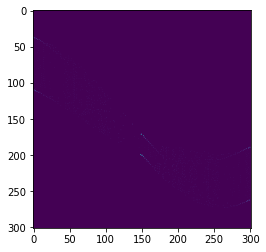

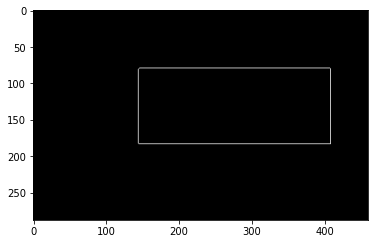

In [182]:
def nonMaxima2(image):
    image = np.copy(image)

    height, width = image.shape
    image = np.pad(image,1)
    
    #samo na sredini lukna
    mask = np.ones((3,3))
    mask[1,1] = 0

    for x in range(1,height+1):
        for y in range(1, width+1):
            #if its not the largest?
            if image[x,y] > 0 and  not image[x,y] > np.max(image[x-1:x+2, y-1:y+2]*mask):
                image[x,y] = 0
                
    return image[1:height+1, 1: width+1]

rectangle = cv2.imread("images/rectangle.png")
rectangle = cv2.cvtColor(rectangle, cv2.COLOR_BGR2GRAY)

#builtin canny
rectangleEdges = cv2.Canny(rectangle, 50, 100)

accArray = houghFindLines(rectangleEdges, 300, 300)

#accArraySup = accArray
accArraySup = nonMaxima2(accArray)

plt.imshow(accArraySup)

#plt.imshow(accArray)
plt.show()
plt.imshow(rectangleEdges, cmap="gray")

(732,)
(460,)


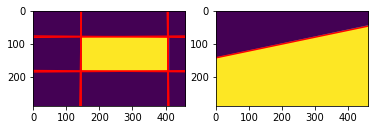

In [183]:
def draw_line(rho, theta, max_rho):
	a = np.cos(theta)
	b = np.sin(theta)

	x0 = a*rho
	y0 = b*rho

	x1 = int(x0 + max_rho*(-b))
	y1 = int(y0 + max_rho*(a))
	x2 = int(x0 - max_rho*(-b))
	y2 = int(y0 - max_rho*(a))

	plt.plot((y1,y2),(x1,x2),'r')
	#plt.plot((x1, x2), (y1, y2),  'r')


plt.subplot(121)
rectangle = cv2.imread("images/rectangle.png")
rectangle = cv2.cvtColor(rectangle, cv2.COLOR_BGR2GRAY)

rectangleEdges = cv2.Canny(rectangle, 50, 100)

selectedTheta = 200
selectedRho = 800

accArray = houghFindLines(rectangleEdges, selectedTheta, selectedRho)

#accArraySup = accArray
accArraySup = nonMaxima2(accArray)

height, width = rectangleEdges.shape
maxRho = np.sqrt(height**2 + width**2)

valuesTheta = (np.linspace(-90, 90, selectedTheta) / 180) * np.pi # Values of theta are known
valuesRho = np.linspace(-maxRho, maxRho, selectedRho)


for rho,theta in np.argwhere(accArraySup > 70):	
	draw_line(valuesRho[rho], valuesTheta[theta], maxRho)

# for i in range (len(accArraySup)):
# 	for j in range  (len(accArraySup[0])):
# 		if accArraySup[i,j] > 200:
# 			draw_line(i,j,maxRhoo)


plt.imshow(rectangle)
plt.subplot(122)

selectedTheta = 300
selectedRho = 300
accArray = houghFindLines(onelineeEdges, 300, 300)

#accArraySup = accArray
accArraySup = nonMaxima2(accArray)

height, width = onelineeEdges.shape
maxRho = np.sqrt(height**2 + width**2)

valuesTheta = (np.linspace(-90, 90, selectedTheta) / 180) * np.pi # Values of theta are known
valuesRho = np.linspace(-maxRho, maxRho, selectedRho)


for rho,theta in np.argwhere(accArraySup > 200):	
	draw_line(valuesRho[rho], valuesTheta[theta], maxRho)

plt.imshow(oneline)

## 3.d) Hough on images

(35904,)


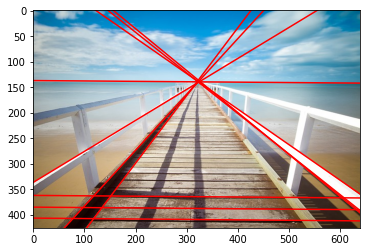

In [184]:
bricks = cv2.imread("images/pier.jpg")
bricks = cv2.cvtColor(bricks, cv2.COLOR_BGR2RGB)
bricksEdges = cv2.cvtColor(bricks, cv2.COLOR_RGB2GRAY)


#builtin canny
bricksEdges = cv2.Canny(bricksEdges, 40, 100)
plt.imshow(bricksEdges, cmap="gray")


def plotImageAndLines(imageEdges, numThetas, numRhos):
	accArray = houghFindLines(imageEdges, numThetas, numRhos)
	accArraySup = nonMaxima2(accArray)

	height, width = imageEdges.shape
	maxRho = np.sqrt(height**2 + width**2)

	valuesTheta = (np.linspace(-90, 90, numThetas) / 180) * np.pi # Values of theta are known
	valuesRho = np.linspace(-maxRho, maxRho, numRhos)

	for rho,theta in np.argwhere(accArraySup > 200):	
		draw_line(valuesRho[rho], valuesTheta[theta], maxRho)



def plotNLines(imageEdges, numThetas, numRhos, N):
	accArray = houghFindLines(imageEdges, numThetas, numRhos)
	accArraySup = nonMaxima2(accArray)

	height, width = imageEdges.shape
	maxRho = np.sqrt(height**2 + width**2)

	valuesTheta = (np.linspace(-90, 90, numThetas) / 180) * np.pi # Values of theta are known
	valuesRho = np.linspace(-maxRho, maxRho, numRhos)


	indRho, indTheta = np.unravel_index(np.argsort(-accArraySup, axis=None,), accArraySup.shape)

	for i in range (N):
		draw_line(valuesRho[indRho[i]], valuesTheta[indTheta[i]], maxRho)

#plotImageAndLines(bricksEdges, 200, 800)

#plotNLines(bricksEdges, 200, 800, 10)
plotNLines(bricksEdges, 200, 800, 10)
plt.imshow(bricks)

plt.show()



(20624,)


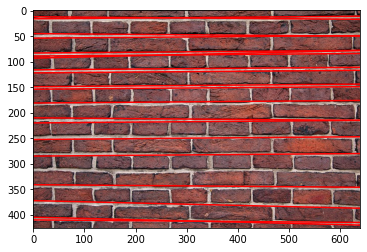

In [185]:
bricks = cv2.imread("images/bricks.jpg")
bricks = cv2.cvtColor(bricks, cv2.COLOR_BGR2RGB)
bricksEdges = cv2.cvtColor(bricks, cv2.COLOR_RGB2GRAY)
bricksEdges = cv2.Canny(bricksEdges, 300, 600)

plotNLines(bricksEdges, 200, 800, 20)

#builtin canny

plt.imshow(bricks)